# Import

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as tc
from torch import nn
from preprocess import preprocess_dataframe, make_tensordata
#from visual import plot_demo, plot_series
from model import train_model, LSTMModel

# Plot function

In [2]:
"""import numpy as np
import matplotlib.pyplot as plt
import torch as tc"""


def plot_demo(
        df, 
        train_mean,
        train_std,
        input_col_names=None, 
        label_col_names=['Kp'], 
        plot_col_name='Kp',
        t_res='1min',
        input_window=1, 
        label_window=1, 
        offset=0, 
        max_demos=3, 
        model=None
    ):

    data_len = len(df)
    max_demos = min(max_demos, data_len)

    demo_idxs = np.random.choice(data_len, size=max_demos, replace=False)

    input_col_names = input_col_names
    if input_col_names is None:
        input_col_names = [name for name in df.columns]

    label_col_names = label_col_names
    if label_col_names is None:
        label_col_names = [name for name in df.columns]

    plot_col_name = plot_col_name
    if plot_col_name is None:
        plot_col_name = label_col_names[0]

    mean = train_mean[plot_col_name]
    std = train_std[plot_col_name]

    if model is not None:
        inputs = []
        for i in demo_idxs:
            input = df[input_col_names][i:i+input_window].to_numpy()
            inputs.append(input)
        inputs = tc.tensor(np.array(inputs))
        preds = model(inputs).detach().numpy() * std + mean

    input_idxs = np.arange(-input_window + 1, 0 + 1)
    label_idxs = np.arange(offset, offset + label_window)
    total_idxs = np.arange(-input_window+1, offset+label_window)

    series = df[plot_col_name] * std + mean

    for j, i in enumerate(demo_idxs):
        plt.figure(figsize=(20, 7.5))
        plt.plot(input_idxs, series[i:i+input_window], 'k.', ms=20, label='Input')
        if plot_col_name in label_col_names:
            plt.plot(label_idxs, series[i+input_window+offset:i+input_window+offset+label_window], 'ko', mfc='w', ms=20, label='Label')
            if model is not None:
                plt.plot(label_idxs, preds[j, :, :], 'b.', ms=20, label='Pred')
        plt.xticks(ticks=total_idxs, labels=total_idxs, fontsize=20)
        plt.yticks(ticks=range(10), labels=range(10), fontsize=20)
        plt.xlabel(f'Time shift (x{t_res})', fontsize=30)
        plt.ylabel(plot_col_name, fontsize=30)
        
        plt.legend(fontsize=20) 
        plt.grid()
        plt.show()


def plot_series_pred(df, input_col_names, mean, std, model, start_idx, end_idx, input_window, label_window, offset):
    loss_fn = nn.MSELoss()
    input_idxs = slice(start_idx, end_idx - offset - label_window + 1)
    inputs = tc.tensor(df[input_col_names][input_idxs].to_numpy()).unsqueeze(0)

    pred_idxs = slice(start_idx + offset, end_idx)
    labels = tc.tensor(df['Kp'][pred_idxs].to_numpy()) #.unsqueeze(0)
    preds = model(inputs, return_series=True).squeeze()
    loss = loss_fn(preds, labels)

    pred_ts = df.index[pred_idxs]
    preds = preds.detach().numpy() * std + mean
    plt.plot(pred_ts, preds, 'b-', label='Series pred')
    return np.sqrt(loss.squeeze().detach().numpy())

def plot_batch_pred(df, input_col_names, mean, std, model, start_idx, end_idx, input_window, label_window, offset):
    loss_fn = nn.MSELoss()
    pred_start_idxs = range(start_idx, end_idx - input_window - offset - label_window + 2)
    pred_ts = []
    preds = []
    loss_running_sum = 0
    for i in pred_start_idxs:
        pred_idx = slice(i + input_window + offset - 1, i + input_window + offset - 1 + label_window)
        pred_t = df.index[pred_idx]
        pred_ts.append(pred_t)

        input = tc.tensor(df[input_col_names][i : i + input_window].to_numpy()).unsqueeze(0)
        label = tc.tensor(df['Kp'][pred_idx].to_numpy()).squeeze()
        pred = model(input, return_series=False).squeeze()

        loss = loss_fn(pred, label)
        loss_running_sum += loss
        pred_pt = pred.detach().numpy() * std + mean
        preds.append(pred_pt)
    plt.plot(pred_ts, preds, 'g-', label='Batch pred')
    return np.sqrt(np.sum(loss_running_sum.squeeze().detach().numpy())/len(pred_start_idxs))

def plot_series(
        df,
        train_mean,
        train_std,
        input_col_names=None, 
        label_col_names=['Kp'], 
        plot_col_name='Kp', 
        start=None, 
        end=None,
        input_window=1, 
        label_window=1, 
        offset=0, 
        model=None,
        pred_type='both'
    ):
    
    data_len = len(df)

    input_col_names = input_col_names
    if input_col_names is None:
        input_col_names = [name for name in df.columns]

    label_col_names = label_col_names
    if label_col_names is None:
        label_col_names = [name for name in df.columns]

    plot_col_name = plot_col_name
    if plot_col_name is None:
        plot_col_name = label_col_names[0]

    start_idx = 0
    if isinstance(start, str):
        start_idx = df.index.get_indexer([start], method='nearest')[0]
    elif isinstance(start, int):
        if start < 0:
            start_idx = start + data_len
        else:
            start_idx = start
    
    end_idx = data_len
    if isinstance(end, str):
        end_idx = df.index.get_indexer([end], method='nearest')[0]
    elif isinstance(end, int):
        if end < 0:
            end_idx = end + data_len
        else:
            end_idx = end

    mean = train_mean[plot_col_name]
    std = train_std[plot_col_name]
    series = df[plot_col_name] * std + mean
    
    data_idxs = slice(start_idx, end_idx)
    #std[data_idx]
    data_ts = df.index[data_idxs]
    data_pts = series[data_idxs]

    plt.figure(figsize=(20, 10))

    plt.plot(data_ts, data_pts, 'k-', mfc='w', label='Data')

    title = ''
    if model is not None and plot_col_name in label_col_names:
        if pred_type == 'series':
            series_rmse = plot_series_pred(df, input_col_names, mean, std, model, start_idx, end_idx, input_window, label_window, offset)
            title = f'Series RMSE = {series_rmse:.7f}'
        elif pred_type == 'batch':
            batch_rmse = plot_batch_pred(df, input_col_names, mean, std, model, start_idx, end_idx, input_window, label_window, offset)
            title = f'Batch RMSE = {batch_rmse:.7f}'
        elif pred_type == 'both':
            series_rmse = plot_series_pred(df, input_col_names, mean, std, model, start_idx, end_idx, input_window, label_window, offset)
            batch_rmse = plot_batch_pred(df, input_col_names, mean, std, model, start_idx, end_idx, input_window, label_window, offset)
            title = f'RMSE (series, batch) = ({series_rmse:.7f}, {batch_rmse:.7f})'

    plt.title(title, fontsize=20)
    plt.legend(fontsize=20)
    plt.xlabel('Time', fontsize=40)
    plt.ylabel(plot_col_name, fontsize=40)
    plt.xticks(fontsize=20, rotation=-60)
    plt.yticks(ticks=range(10), labels=range(10), fontsize=20)
    plt.ylim(-0.2, data_pts.max()+1)
    plt.grid()
    plt.show()

# Read data

In [3]:
dtype = np.float64
yrs = range(2017, 2018)

dfs = []
for yr in yrs:
    yr_df = pd.read_csv(f'data/annual_data/model_data/model_{yr}_1min_data.csv', index_col='t', parse_dates=True, dtype=dtype)
    dfs.append(yr_df) 
orig_df = pd.concat(dfs)

# Preprocess (resample time resolution, split, standardize, fill nan) data

In [4]:
t_res = pd.Timedelta('1hr')
split_ratio=0.5
fill_nan_val=0

train_df, test_df, train_mean, train_std = preprocess_dataframe(orig_df, t_res, split_ratio, fill_nan_val)

# Make tensordata

In [5]:
input_window = 1 #int(pd.Timedelta('12hr') / t_res)
offset = 1 #int(pd.Timedelta('2hr') / t_res)
label_window = 1

train_inputs, train_labels, test_inputs, test_labels = make_tensordata(
    train_df, 
    test_df, 
    label_col_names=['Kp'], 
    input_window=input_window, 
    label_window=label_window, 
    offset=offset
)

# Train model

## Initialize model

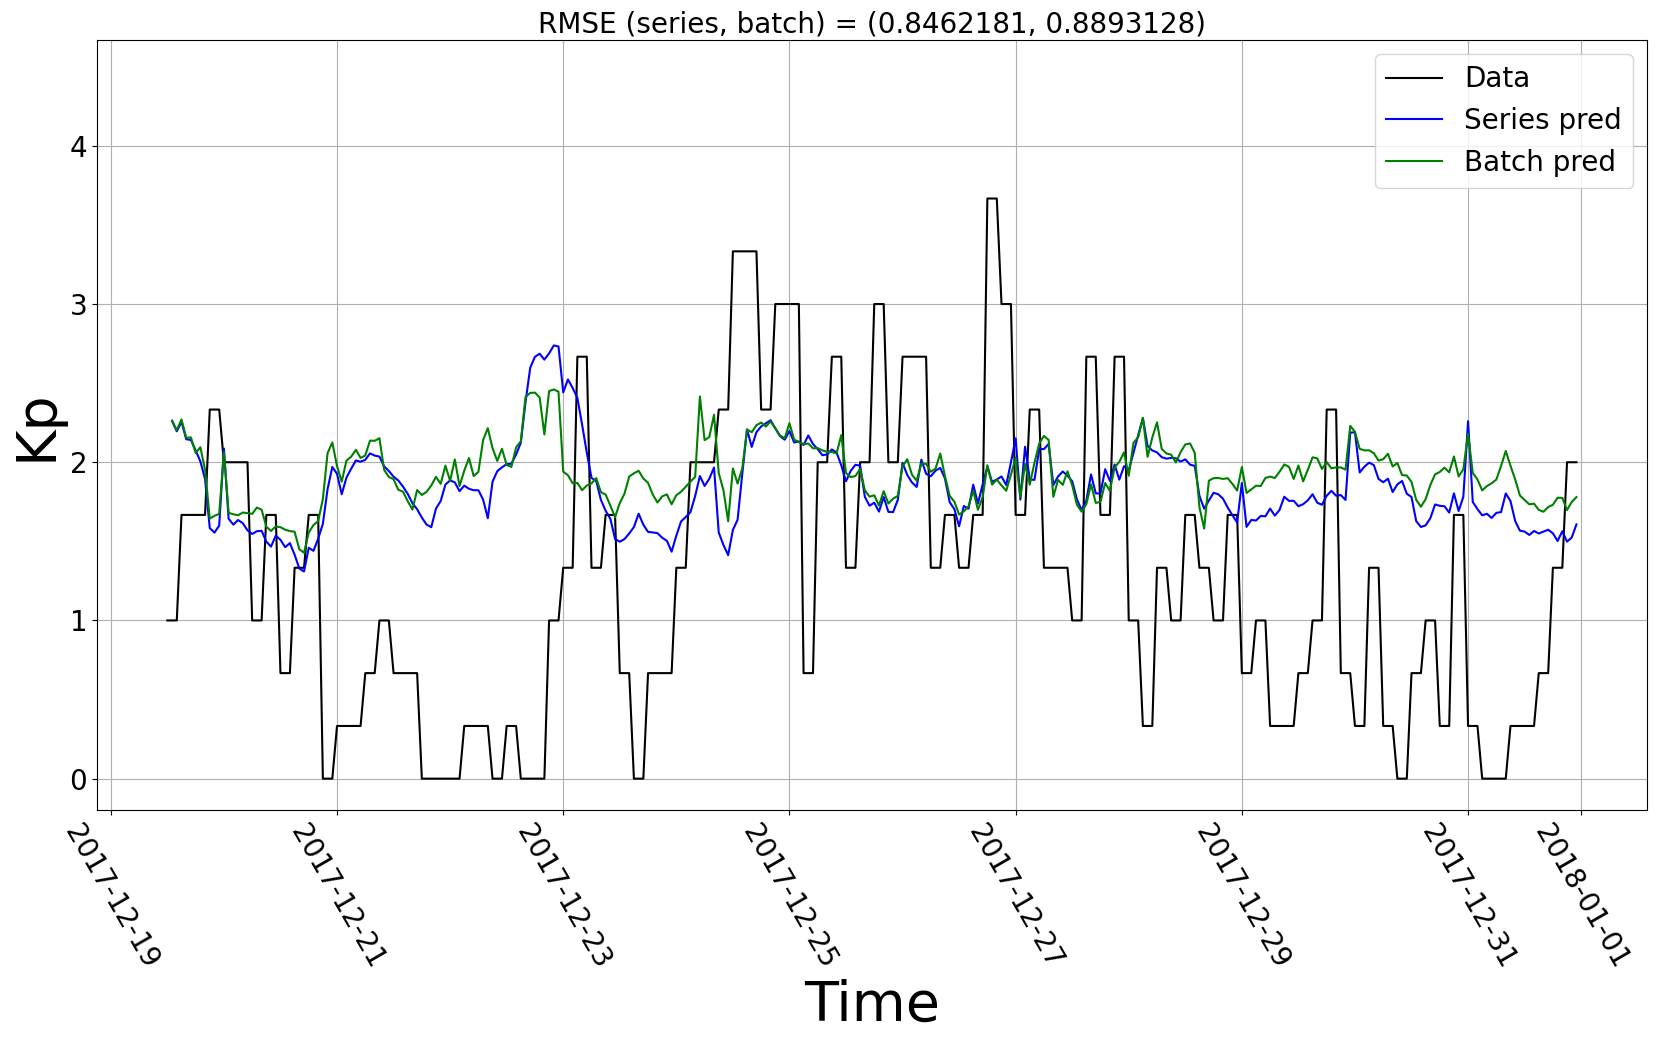

In [6]:
hidden_size = 8

lstm_model = LSTMModel(hidden_size=hidden_size, feature_size=len(train_df.columns), input_window=input_window, label_window=label_window)

plot_series(
    test_df, 
    train_mean, 
    train_std, 
    start=-300, 
    end=None, 
    input_window=input_window, 
    label_window=label_window, 
    offset=offset, 
    model=lstm_model,
    pred_type='both'
)

## Train model

Epoch 1 RMSE: (train, test) = (0.3122597, 0.5022542)
Epoch 2 RMSE: (train, test) = (0.3122592, 0.5022524)
Epoch 3 RMSE: (train, test) = (0.3122588, 0.5022515)
Epoch 4 RMSE: (train, test) = (0.3122584, 0.5022530)
Epoch 5 RMSE: (train, test) = (0.3122581, 0.5022547)
Epoch 6 RMSE: (train, test) = (0.3122577, 0.5022555)
Epoch 7 RMSE: (train, test) = (0.3122573, 0.5022549)
Epoch 8 RMSE: (train, test) = (0.3122569, 0.5022550)
Epoch 9 RMSE: (train, test) = (0.3122566, 0.5022565)
Epoch 10 RMSE: (train, test) = (0.3122563, 0.5022573)


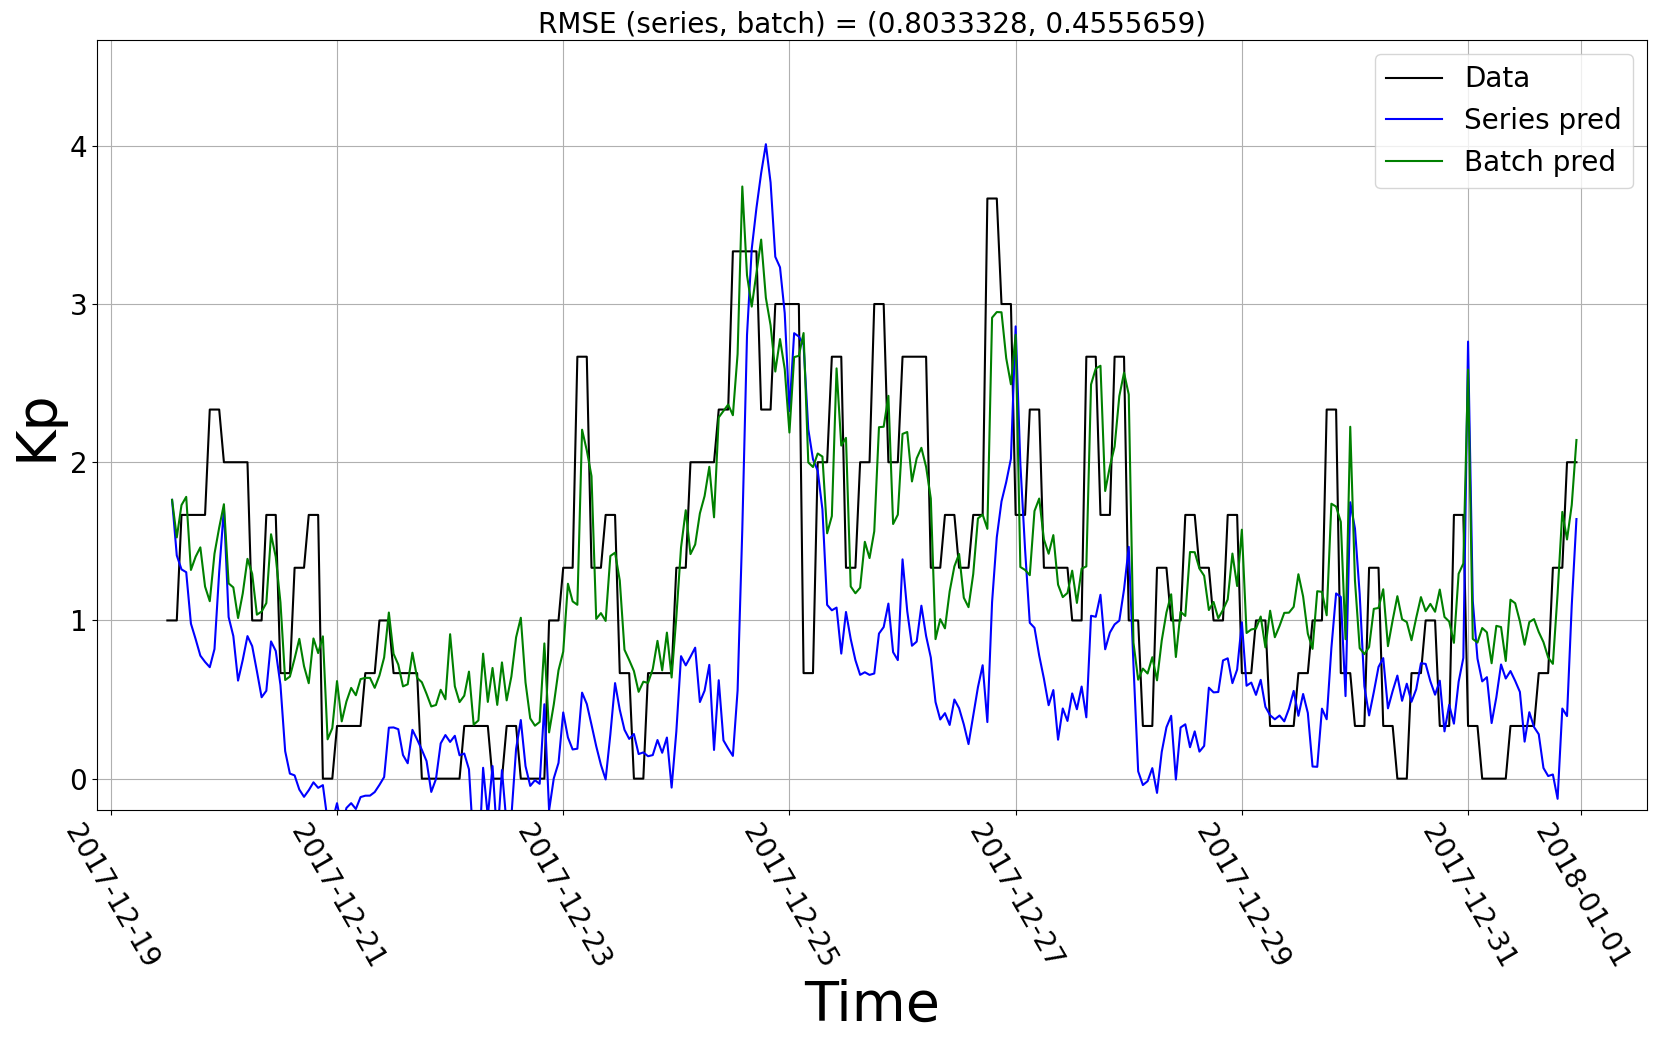

In [33]:
train_model(train_inputs, train_labels, test_inputs, test_labels, model=lstm_model, lr=1e-6, n_epoch=10, batch_size=1024)

plot_series(
    test_df, 
    train_mean, 
    train_std, 
    start=-300, 
    end=None, 
    input_window=input_window, 
    label_window=label_window, 
    offset=offset, 
    model=lstm_model,
    pred_type='both'
)

## Test model

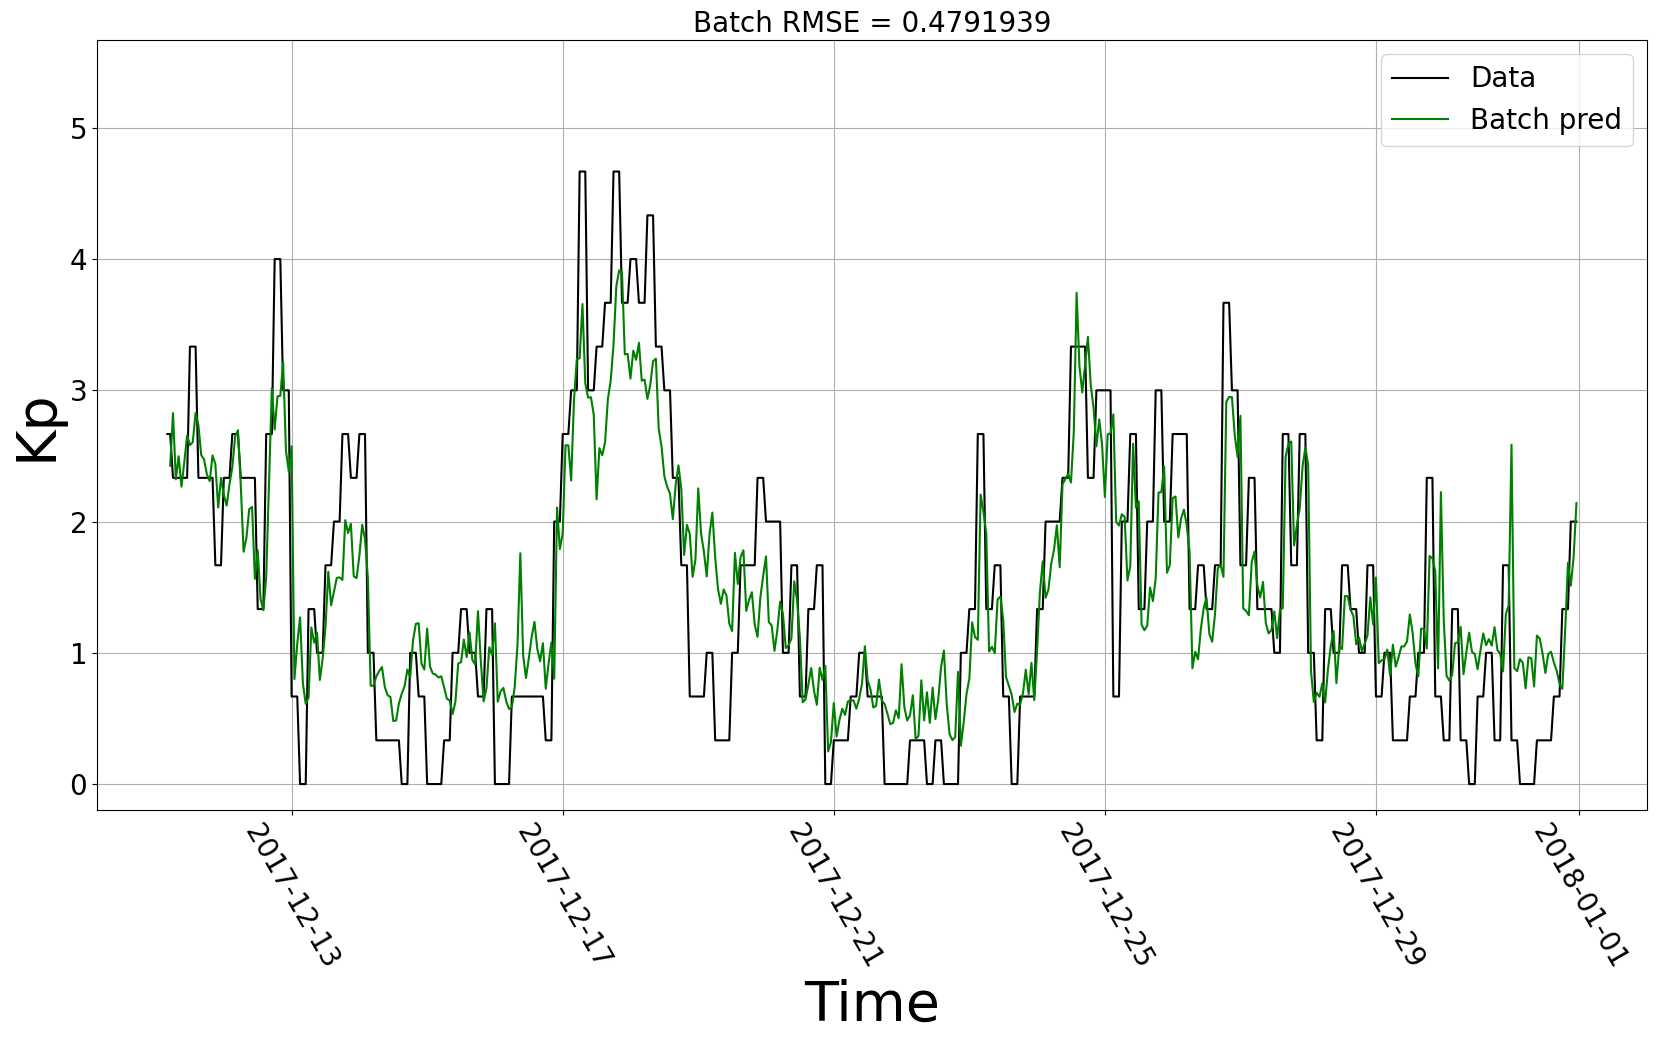

In [40]:
plot_series(
    test_df, 
    train_mean, 
    train_std, 
    start=-500, 
    end=None, 
    input_window=input_window, 
    label_window=label_window, 
    offset=offset, 
    model=lstm_model,
    pred_type='batch'
)

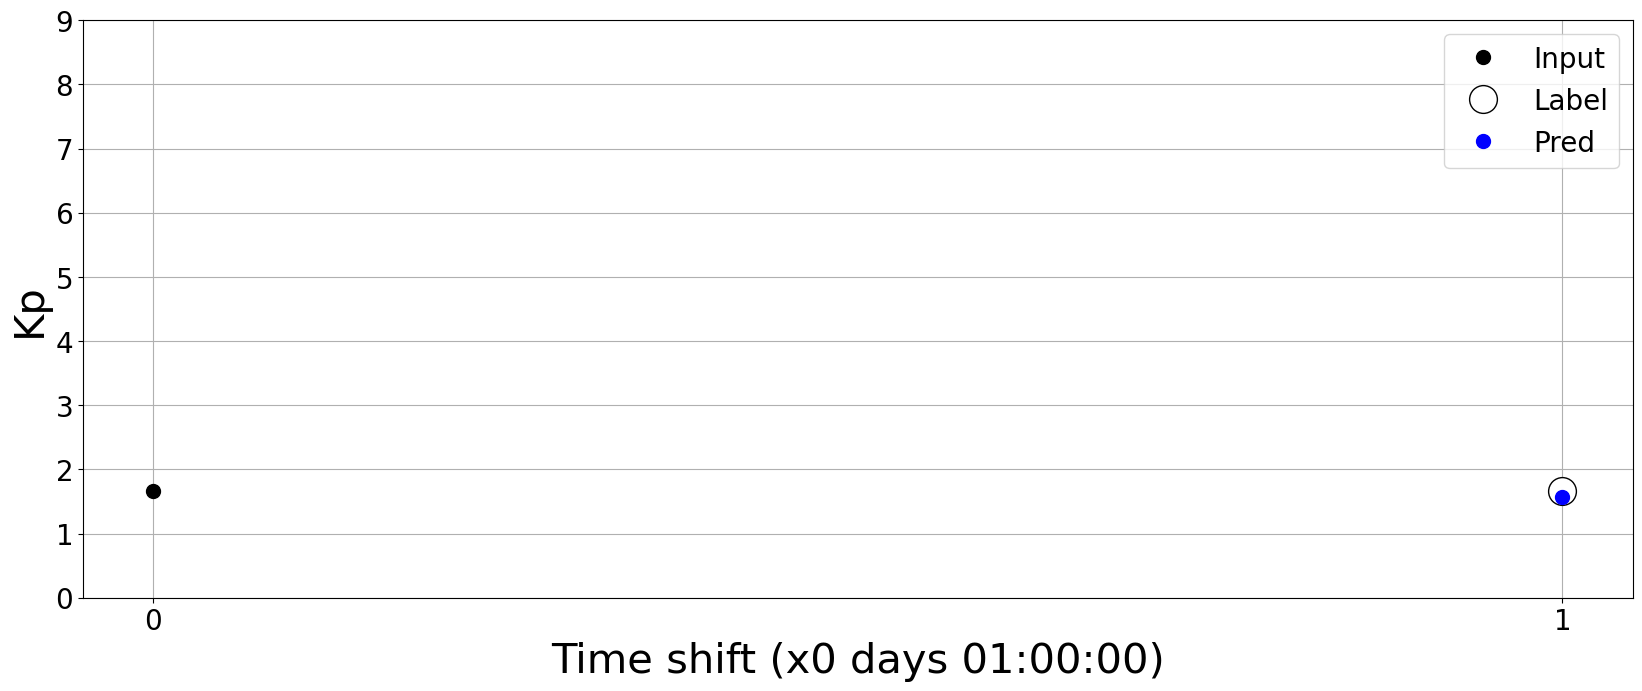

In [177]:
plot_demo(
    test_df, 
    train_mean, 
    train_std, 
    label_col_names=['Kp'], 
    plot_col_name='Kp',
    t_res=t_res,
    input_window=input_window, 
    label_window=label_window, 
    offset=offset,
    max_demos=1,
    model=lstm_model
)

# Save model

In [45]:
#tc.save(lstm_model, f=f'model/-{input_window}hr_+{offset}hr_hid{hidden_size}_lstm')

# Kp correlation

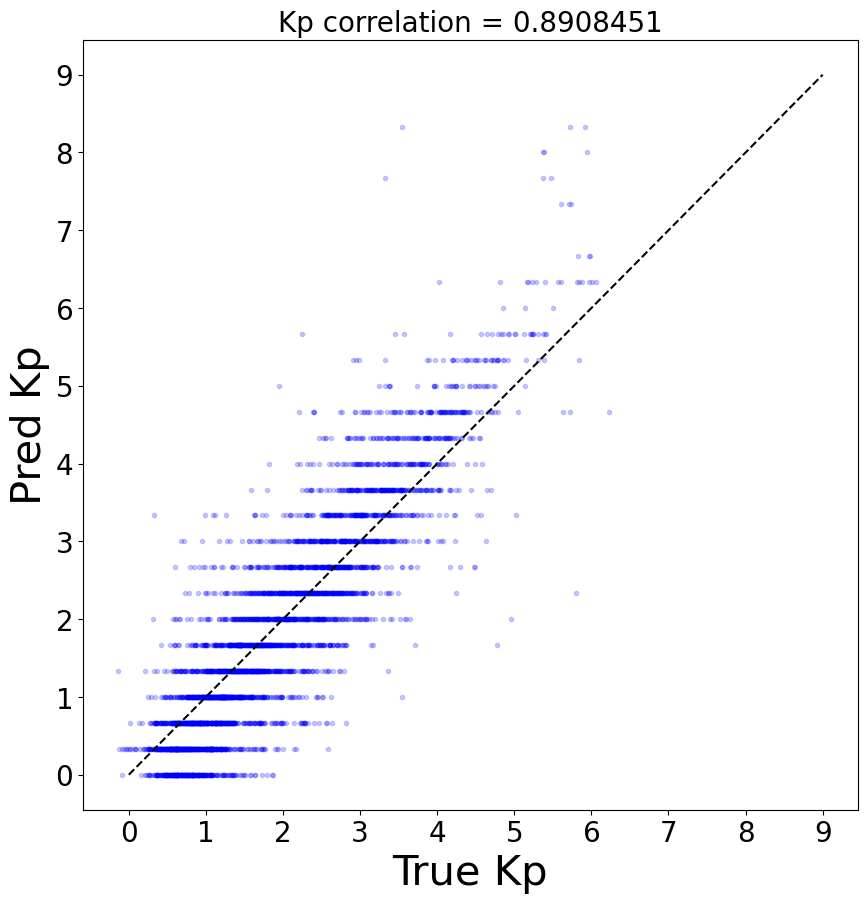

In [96]:
def plot_Kp_correlation(df, input_col_names, mean, std, model, input_window, label_window, offset):

    input_col_names = input_col_names
    if input_col_names is None:
        input_col_names = [name for name in df.columns]

    start_idxs = range(0, len(df) - input_window - offset - label_window + 2)

    labels = []
    preds = []
    for i in start_idxs:
        input_idx = slice(i, i + input_window)
        input = tc.tensor(df[input_col_names][input_idx].to_numpy()).unsqueeze(0)
        pred = model(input, return_series=False).squeeze().detach().numpy() * std + mean

        label_idx = slice(i + input_window + offset - 1, i + input_window + offset - 1 + label_window)
        label = df['Kp'][label_idx].to_numpy().squeeze() * std + mean

        preds.append(pred)
        labels.append(label)

    r = np.corrcoef(preds, labels)[0, 1]
    plt.figure(figsize=(10, 10))
    plt.title(f'Kp correlation = {r:.7f}', fontsize=20)
    plt.plot(preds, labels, 'b.', alpha=0.2)
    plt.plot([0, 9], [0, 9], 'k--')
    plt.xlabel('True Kp', fontsize=30)
    plt.ylabel('Pred Kp', fontsize=30)
    plt.xticks(ticks=range(10), labels=range(10), fontsize=20)
    plt.yticks(ticks=range(10), labels=range(10), fontsize=20)
    plt.show()
    
plot_Kp_correlation(test_df, input_col_names=None, mean=train_mean['Kp'], std=train_std['Kp'], model=lstm_model, input_window=input_window, label_window=label_window, offset=offset)

# Kp persistence

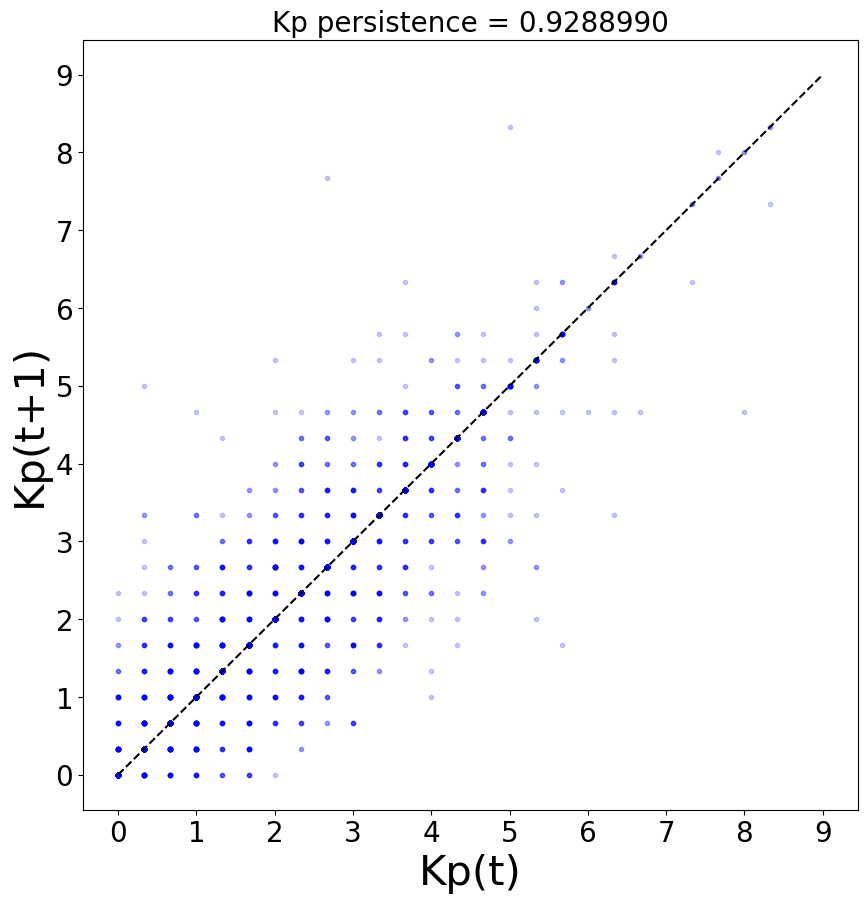

In [94]:
def plot_Kp_persistence(df, mean, std):

    Kps = df['Kp'][:-1] * std + mean
    Kp_plus1s = df['Kp'][1:] * std + mean

    r = np.corrcoef(Kps, Kp_plus1s)[0, 1]
    plt.figure(figsize=(10, 10))
    plt.title(f'Kp persistence = {r:.7f}', fontsize=20)
    plt.plot(Kps, Kp_plus1s, 'b.', alpha=0.2)
    plt.plot([0, 9], [0, 9], 'k--')
    plt.xlabel('Kp(t)', fontsize=30)
    plt.ylabel('Kp(t+1)', fontsize=30)
    plt.xticks(ticks=range(10), labels=range(10), fontsize=20)
    plt.yticks(ticks=range(10), labels=range(10), fontsize=20)
    plt.show()
    
plot_Kp_persistence(test_df, mean=train_mean['Kp'], std=train_std['Kp'])

# Gradient analysis

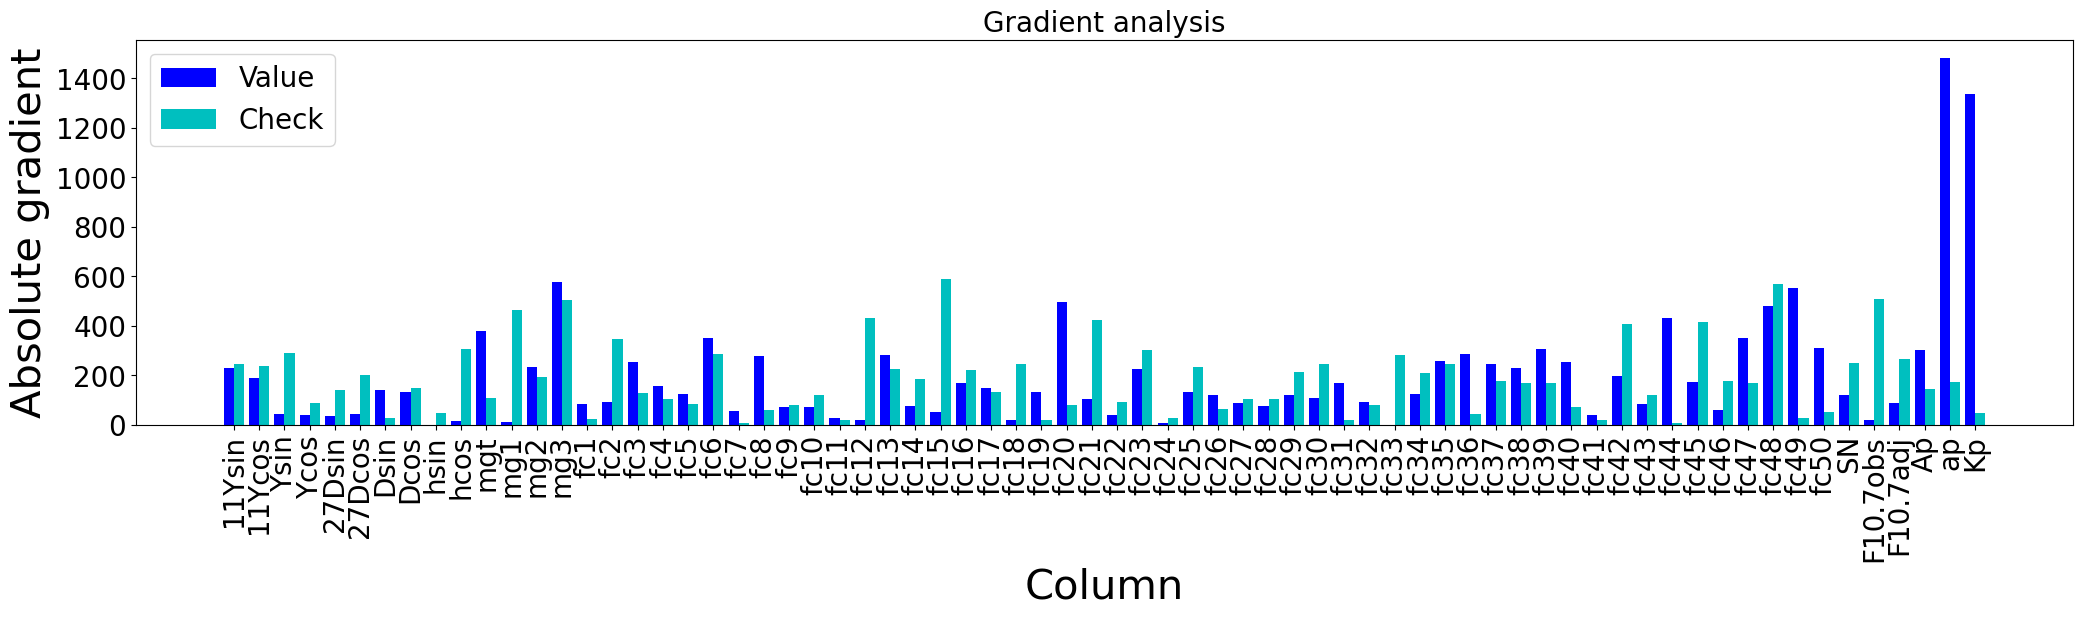

In [323]:
def grad_analysis(df, input_col_names, mean, std, model, input_window, label_window, offset):
    loss_fn = nn.MSELoss()
    input_col_names = input_col_names
    if input_col_names is None:
        input_col_names = [name for name in df.columns]

    start_idxs = range(0, len(df) - input_window - offset - label_window + 2)

    grad_running_sum = np.zeros(len(df.columns))

    for i in start_idxs:
        input_idx = slice(i, i + input_window)
        input = tc.tensor(np.expand_dims(df[input_col_names][input_idx], 0), requires_grad=True)
        pred = model(input)

        label_idx = slice(i + input_window + offset - 1, i + input_window + offset - 1 + label_window)
        label = tc.tensor(np.expand_dims(df['Kp'][label_idx], [0, 1]))

        loss = loss_fn(pred, label)
        pred.backward()
        grad = input.grad

        grad_running_sum += grad.squeeze().detach().numpy()

    bar_width = 0.4
    n_bar = len(df.columns)//2
    bar_idxs = np.arange(n_bar)
    plt.figure(figsize=(25, 5))
    plt.title('Gradient analysis', fontsize=20)
    plt.bar(bar_idxs, np.abs(grad_running_sum)[:n_bar], color='b', width=bar_width, label='Value')
    plt.bar(bar_idxs+bar_width, np.abs(grad_running_sum)[n_bar:], color='c', width=bar_width, label='Check')
    plt.xlabel('Column', fontsize=30)
    plt.ylabel('Absolute gradient', fontsize=30)
    plt.xticks(ticks=bar_idxs+bar_width/2, labels=df.columns[:n_bar], fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

grad_analysis(train_df, input_col_names=None, mean=train_mean['Kp'], std=train_std['Kp'], model=lstm_model, input_window=input_window, label_window=label_window, offset=offset)

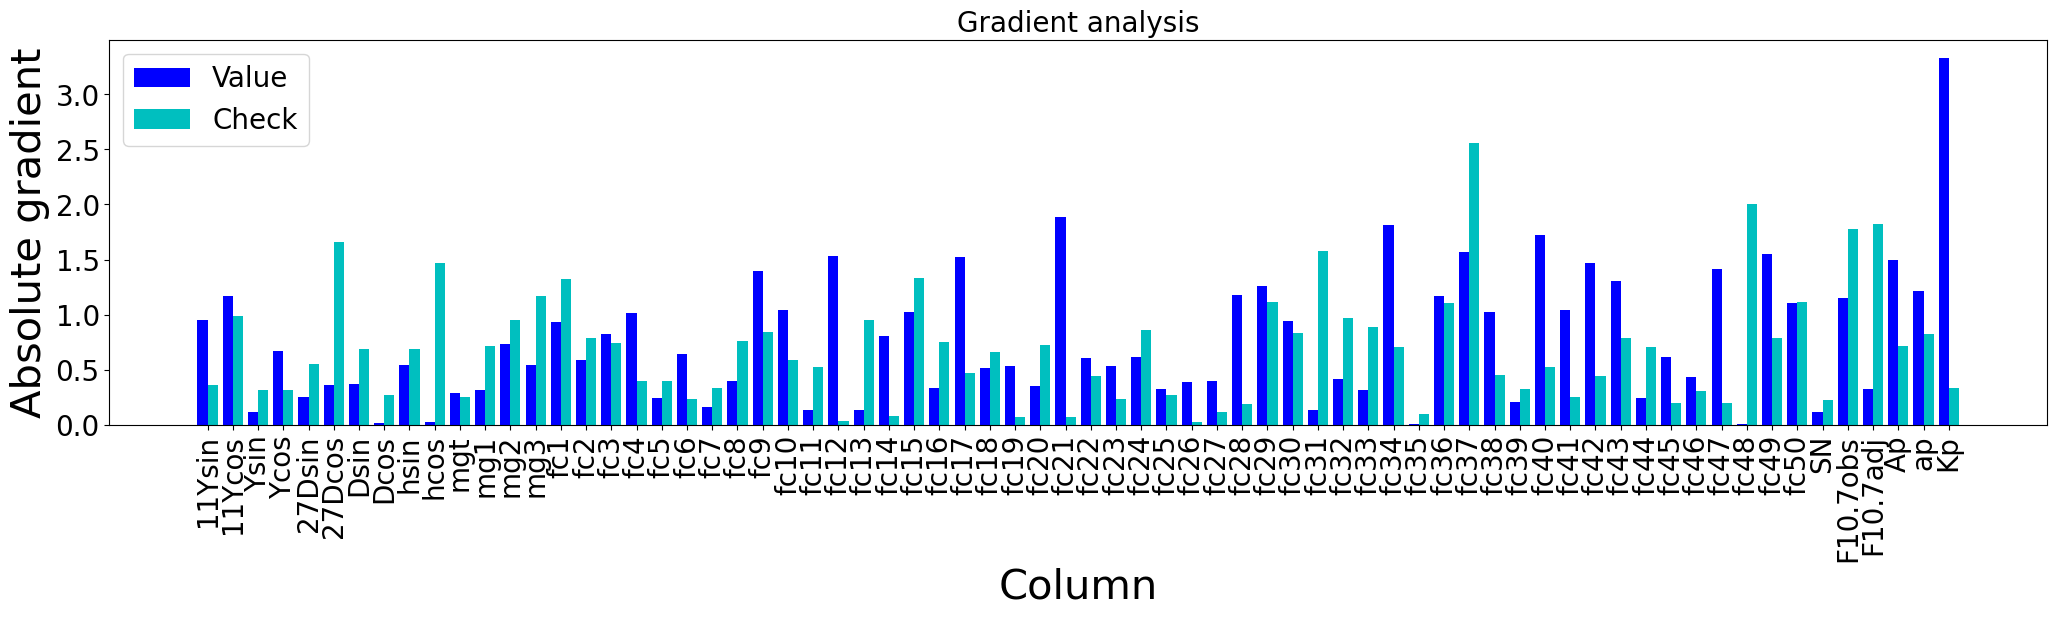

In [224]:
x = tc.tensor([[2.]], requires_grad=True)
y = tc.square(x)
y.backward()
x.grad

tensor([[4.]])

In [206]:
train_inputs.shape

torch.Size([4377, 1, 140])

In [238]:
x = tc.tensor(np.expand_dims(test_df[0:1], 0), requires_grad=True)
print(x)
y = lstm_model(x)
print(y)
y.backward()
print(x.grad)

tensor([[[-1.9949, -1.7056, -2.0739, -1.4134, -0.6905, -1.2651, -0.1840,
          -1.4024, -0.5763,  1.3449,  1.4174,  1.3459,  1.8970,  1.5768,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.5246, -0.6652,
          -0.6252, -0.6182, -0.6259, -0.6178, -0.5218,  0.1629,  1.4287,
           0.8687,  0.3118, -0.0204, -0.1498, -0.2123, -0.2701, -0.3246,
          -0.7960, -0.9684, -0.8818, -0.8041, -0.7226, -0.6363,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000, -0.5438, -0.8499, -0.4398,  0.8465,  0.1888,  0.6087,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0236,  0.0236,  0.0236,  0.0236,
          -0.2453, -0.3075, -0.3921, -0.4690, -0.5374, -0.6051, -0.6908,
          -0.7707, -0.8541, -0.9355, -1.0220, -1.12